In [1]:
import os, sys, glob 
import argparse
parser = argparse.ArgumentParser()
# Dataset
parser.add_argument('--set', type=str, default='valid')
# Model/Config
parser.add_argument('--step', type=str, default='050000')
parser.add_argument('--ckpt_selector', type=str, default='ema')
parser.add_argument('--cfg_name', type=str, default=None)
parser.add_argument('--log_dir', type=str, default=None)
# Interpolation
parser.add_argument('--interpolate', nargs='+', default=None)
parser.add_argument('--interpolate_step', type=int, default=15)
parser.add_argument('--interpolate_noise', action='store_true', default=False)
parser.add_argument('--lerp', action='store_true', default=False)
parser.add_argument('--slerp', action='store_true', default=False)
parser.add_argument('--uncond_sampling', action='store_true', default=False)
parser.add_argument('--uncond_sampling_iters', type=int, default=1)
parser.add_argument('--reverse_sampling', action='store_true', default=False)
parser.add_argument('--separate_reverse_sampling', action='store_true', default=False)
# Samples selection
parser.add_argument('--n_subject', type=int, default=-1)
parser.add_argument('--sample_pair_json', type=str, default=None)
parser.add_argument('--sample_pair_mode', type=str, default=None)
parser.add_argument('--src_dst', nargs='+', default=[])
# Pertubation the image condition
parser.add_argument('--perturb_img_cond', action='store_true', default=False)
parser.add_argument('--perturb_mode', type=str, default='zero')
parser.add_argument('--perturb_where', nargs='+', default=[])

# Rendering
parser.add_argument('--render_mode', type=str, default="shape")
parser.add_argument('--rotate_normals', action='store_true', default=False)
# Diffusion
parser.add_argument('--diffusion_steps', type=int, default=1000)
parser.add_argument('--denoised_clamp', type=float, default=None)
# Misc.
parser.add_argument('--seed', type=int, default=23)
parser.add_argument('--gpu_id', type=str, default="0")
parser.add_argument('--save_intermediate', action='store_true', default=False)
parser.add_argument('--postfix', type=str, default='')
parser.add_argument('--ovr_img', type=str, default=None)
parser.add_argument('--ovr_mod', action='store_true', default=False)
parser.add_argument('--norm_img', action='store_true', default=False)
parser.add_argument('--use_global_norm', action='store_true', default=False)
parser.add_argument('--norm_space', type=str, default='rgb')

args = parser.parse_args(args=[])

import os, sys, glob
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL, cv2
import json
import copy
import time
import torchvision
import pytorch_lightning as pl
sys.path.insert(0, '../../../')
from guided_diffusion.script_util import (
    seed_all,
)

from guided_diffusion.tensor_util import (
    make_deepcopyable,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, figsize=(8, 6)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

# Sample utils
sys.path.insert(0, '../../')
from sample_utils import (
    ckpt_utils, 
    params_utils, 
    vis_utils, 
    file_utils, 
    inference_utils, 
    mani_utils,
)
device = 'cuda' if th.cuda.is_available() and th._C._cuda_getDeviceCount() > 0 else 'cpu'

In [2]:
seed_all(47)

################ SETTINGS ################
args.cfg_name = "Masked_Face_woclip_no_nonspatial.yaml"
args.log_dir = "Masked_Face_woclip_no_nonspatial"
args.step = '050000'
args.ckpt_selector = 'ema'
args.set = 'valid'
args.sample_pair_json = './sample_json/ipynb_samples.json'
args.sample_pair_mode = 'pair'

# Load Ckpt
if args.cfg_name is None:
    args.cfg_name = args.log_dir + '.yaml'
ckpt_loader = ckpt_utils.CkptLoader(log_dir=args.log_dir, cfg_name=args.cfg_name)
cfg = ckpt_loader.cfg

print(f"[#] Sampling with diffusion_steps = {args.diffusion_steps}")
cfg.diffusion.diffusion_steps = args.diffusion_steps
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=args.ckpt_selector, step=args.step)
model_dict = inference_utils.eval_mode(model_dict)

# Load dataset
if args.set == 'itw':
    img_dataset_path = "../../itw_images/aligned/"
    deca_dataset_path = None
elif args.set == 'train' or args.set == 'valid':
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
else: raise NotImplementedError

loader, dataset, avg_dict = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector,
    rmv_params=cfg.param_model.rmv_params,
    set_=args.set,
    cfg=cfg,
    mode='sampling'
)

# DECA Rendering
if np.any(['deca_masked' in n for n in list(filter(None, dataset.condition_image))]):
    mask = params_utils.load_flame_mask()
else: 
    mask=None
deca_obj = params_utils.init_deca(mask=mask)

[#] Model Path : 
#0 : /data/mint/model_logs_mount/v6/Masked_Face_woclip_no_nonspatial/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/Brightness_Exp/Masked_Face_woclip_no_nonspatial.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/Brightness_Exp/Masked_Face_woclip_no_nonspatial.yaml')

[#] Sampling with diffusion_steps = 1000
[#] Available ckpt :  ['_000000.pt', '_000000.pt', '_010000.pt', '_010000.pt', '_020000.pt', '_020000.pt', '_030000.pt', '_030000.pt', '_040000.pt', '_040000.pt', '_050000.pt', '_050000.pt', '_060000.pt', '_060000.pt', '_070000.pt', '_070000.pt', '_080000.pt', '_080000.pt', '_090000.pt', '_090000.pt', '_100000.pt', '_100000.pt', '_110000.pt', '_110000.pt', '_120000.pt', '_120000.pt', '_130000.pt', '_130000.pt', '_140000.pt', '_140000.pt', '_150000.pt', '_150000.pt', '_160000.pt', '_160000.pt', '_170000.pt', '_170000.pt', '_180000.pt', '_180000.pt', '_190000.pt', '_190000.pt', '_200000.pt', '_200000.pt', '_210000.pt', '

Loading deca params...: 100%|███████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  []
Remove keys :  []
Input Image :  ['raw']
Image condition :  ['deca_masked_face_images_woclip']
DPM Image condition :  [None]
creating the FLAME Decoder
[#] DECA : SRenderY applied mask


In [3]:
data_size = dataset.__len__()
img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{args.set}")


denoised_fn = None
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, 
                                            diffusion=diffusion, 
                                            reverse_fn=diffusion.ddim_reverse_sample_loop, 
                                            forward_fn=diffusion.ddim_sample_loop,
                                            denoised_fn=denoised_fn,
                                            cfg=cfg,
                                            args=args)

def rgb_to_gray(img):
    out = (img[:, 0:1] * 0.2989) + (img[:, 1:2] * 0.5870) + (img[:, 2:3] * 0.1140)
    return out

# Manipulate the condition

In [4]:
def make_condition(cond, src_idx, dst_idx, n_step=2, itp_func=None):
    condition_img = list(filter(None, dataset.condition_image))
    misc = {'condition_img':condition_img,
            'src_idx':src_idx,
            'dst_idx':dst_idx,
            'n_step':n_step,
            'avg_dict':avg_dict,
            'dataset':dataset,
            'args':args,
            'itp_func':itp_func,
            'img_size':cfg.img_model.image_size,
            'deca_obj':deca_obj
            }  
    if itp_func is not None:
        cond['use_render_itp'] = False 
    else:
        cond['use_render_itp'] = True
        
    cond, clip_ren = inference_utils.build_condition_image(cond=cond, misc=misc)
    cond = inference_utils.prepare_cond_sampling(cond=cond, cfg=cfg, use_render_itp=True)
    

    if 'render_face' in args.interpolate:
        interp_set = args.interpolate.copy()
        interp_set.remove('render_face')
    interp_cond = mani_utils.iter_interp_cond(cond, interp_set=interp_set, src_idx=src_idx, dst_idx=dst_idx, n_step=n_step, interp_fn=itp_func)
    cond.update(interp_cond)
        
    repeated_cond = mani_utils.repeat_cond_params(cond, base_idx=src_idx, n=n_step, key=mani_utils.without(cfg.param_model.params_selector, args.interpolate + ['light', 'img_latent']))
    cond.update(repeated_cond)

    # Finalize the cond_params
    cond = mani_utils.create_cond_params(cond=cond, key=mani_utils.without(cfg.param_model.params_selector, cfg.param_model.rmv_params))
    if cfg.img_cond_model.override_cond != '':
        to_tensor_key = ['cond_params'] + cfg.param_model.params_selector + [cfg.img_cond_model.override_cond]
    else:    
        to_tensor_key = ['cond_params'] + cfg.param_model.params_selector
    cond = inference_utils.to_tensor(cond, key=to_tensor_key, device=ckpt_loader.device)
    
    return cond
    

# Inversion 

[#] Interpolate with <function slerp at 0x7f4121c93ee0>
Rendering time :  1.2477896213531494
[#] Repeating cond :  []
[#] Condition build from parameters in  []


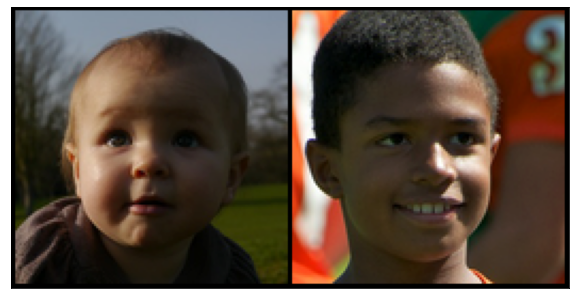

In [30]:
from pytorch_lightning import seed_everything


all_img_idx, all_img_name, args.n_subject = mani_utils.get_samples_list(args.sample_pair_json, 
                                                                        args.sample_pair_mode, 
                                                                        args.src_dst, img_path, 
                                                                        args.n_subject)

idx = 1 # Sample index related to json order
img_idx = all_img_idx[idx]
img_name = all_img_name[idx]

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=2,
                                    shuffle=False, num_workers=2)
                            
# Load image & condition                            
dat, model_kwargs = list(iter(subset_loader))[0]
show(torchvision.utils.make_grid((dat + 1) * 0.5), figsize=(10, 10))

args.interpolate = ['render_face']
cond = copy.deepcopy(model_kwargs)
cond = make_condition(cond=cond, 
                      src_idx=0, dst_idx=1, 
                      n_step=20, itp_func=mani_utils.slerp)
cond['use_cond_xt_fn'] = False
cond['dpm_cond_img'] = None 


cond_rev = pl_sampling.forward_cond_network(model_kwargs={'cond_img':cond['cond_img'][0:1]})

In [21]:
cond_rev['use_cond_xt_fn'] = False
cond_rev['dpm_cond_img'] = None 
    
reverse_ddim_sample = pl_sampling.reverse_proc(dat, cond_rev, store_mean=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
rev_mean = reverse_ddim_sample['intermediate']
# rev_mean WILL BE MODIFIED!!
sample_ddim = pl_sampling.forward_proc(
    noise=reverse_ddim_sample['final_output']['sample'],
    model_kwargs=cond_rev,
    store_intermediate=False,
    rev_mean=rev_mean)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
for x in cond:
    print(x)
cond_relight["cond_img"].shape

deca_masked_face_images_woclip_img
shape
pose
exp
cam
light
faceemb
tform
albedo
detail
shadow
image_name
raw_image
raw_image_path
image
use_render_itp
deca_masked_face_images_woclip
dpm_cond_img
cond_img
use_cond_xt_fn
spatial_latent


torch.Size([20, 3, 128, 128])

In [38]:
cond_relight = pl_sampling.forward_cond_network(model_kwargs=cond)

# use only the noisemap, mean of the first input person in the batch dim
noise_map = reverse_ddim_sample['final_output']['sample'][:1]
rev_mean_first = [x[:1] for x in rev_mean] 

relight_out = pl_sampling.forward_proc(
    noise=th.repeat_interleave(noise_map, repeats=cond_relight["cond_img"].shape[0], dim=0),
    model_kwargs=cond_relight,
    store_intermediate=False,
    add_mean=rev_mean_first)


  0%|          | 0/1000 [00:00<?, ?it/s]

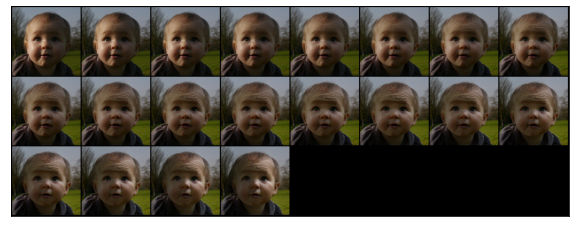

In [39]:
relight_output = relight_out["final_output"]["sample"]
show(torchvision.utils.make_grid((relight_output + 1) * 0.5), figsize=(10, 10))

In [44]:

for i in range(relight_output.shape[0]):
    torchvision.utils.save_image(th.clip((relight_output[i] + 1) * 0.5, 0, 1), f'/data/supasorn/relight/output/{i:02d}.png')

In [50]:
count = 0
for j in range(10):
    for i in range(relight_output.shape[0]):
        torchvision.utils.save_image(th.clip((relight_output[i] + 1) * 0.5, 0, 1), f'/data/supasorn/relight/output2/{count:02d}.png')
        count += 1
    for i in range(relight_output.shape[0]-1, -1, -1):
        torchvision.utils.save_image(th.clip((relight_output[i] + 1) * 0.5, 0, 1), f'/data/supasorn/relight/output2/{count:02d}.png')
        count += 1